In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp

from collections import Counter
from glob import glob
from matplotlib import cm
from scipy.stats import zscore
from sklearn.manifold import MDS


# 1. Descriptives

## 1.1 Initialize and Preprocess

### 1.1.1 Load and Convert to DF

In [2]:
ent_obj = pickle.load(open('data/temp_ent_obj.pickle', 'rb'))
word_count_df, additional_df = ent_obj.convert_to_dataframe(additional_cols=['date', 'domain', 'journal'])

### 1.2.1 Downsample PloS One articles

In [11]:
np.random.seed(1)
n_plos_indx = np.where(additional_df.journal == 'PloS one')[0]
n_plos = len(n_plos_indx)
n_sr = (additional_df.journal == 'Scientific reports').sum()
rand_indx = np.random.permutation(n_plos)

plos_exclude = n_plos_indx[rand_indx[:(n_plos - n_sr)]]
plos_exclude_pmids = list(additional_df.iloc[plos_exclude, :].index)
word_count_df = word_count_df.drop(plos_exclude_pmids).copy()
additional_df = additional_df.drop(plos_exclude_pmids).copy()

## 1.2. Domain Embeddings

### 1.2.1. Compute Entity by Domain Count Matrix

In [12]:
ent_by_domain = word_count_df.groupby(additional_df['domain']).sum()
domain_count = additional_df.groupby('domain').size()
domains = list(ent_by_domain.index)

### 1.2.2 Compute MDS embedding and visualize

In [13]:
embedding = MDS().fit_transform(zscore(ent_by_domain.values.T).T)

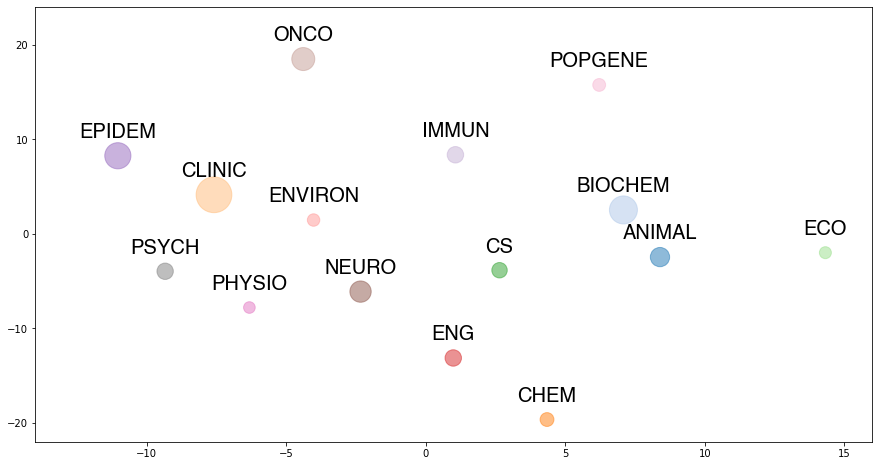

In [16]:
cmap = cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(embedding[:,0], embedding[:,1], s=domain_count/100, color=cmaplist[:15], cmap=cmap, alpha=0.5)
plt.ylim([-22, 24])
plt.xlim([-14, 16])
# zip joins x and y coordinates in pairs
for x, y, domain in zip(embedding[:,0], embedding[:,1], domains):
    
    label = "{:.2f}".format(y)
    # this method is called for each point
    ax.annotate(domain, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,18), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 size=20, weight='bold', fontname='Helvetica') 
plt.savefig('/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure2/Domain_Embedding.png')

## 1.3. Journal Counts by Domain

### 1.3.1 Get Top Journal Counts

In [17]:
domain_by_journal = additional_df['domain'].groupby([additional_df['journal'], additional_df['domain']]).size()
journal_by_domain = additional_df['journal'].groupby([additional_df['domain'], additional_df['journal']]).size()

journal_top_by_domain = journal_by_domain.groupby('journal').apply(lambda x: x.sort_values(ascending=False)[:10])

### 1.3.2 Visualize

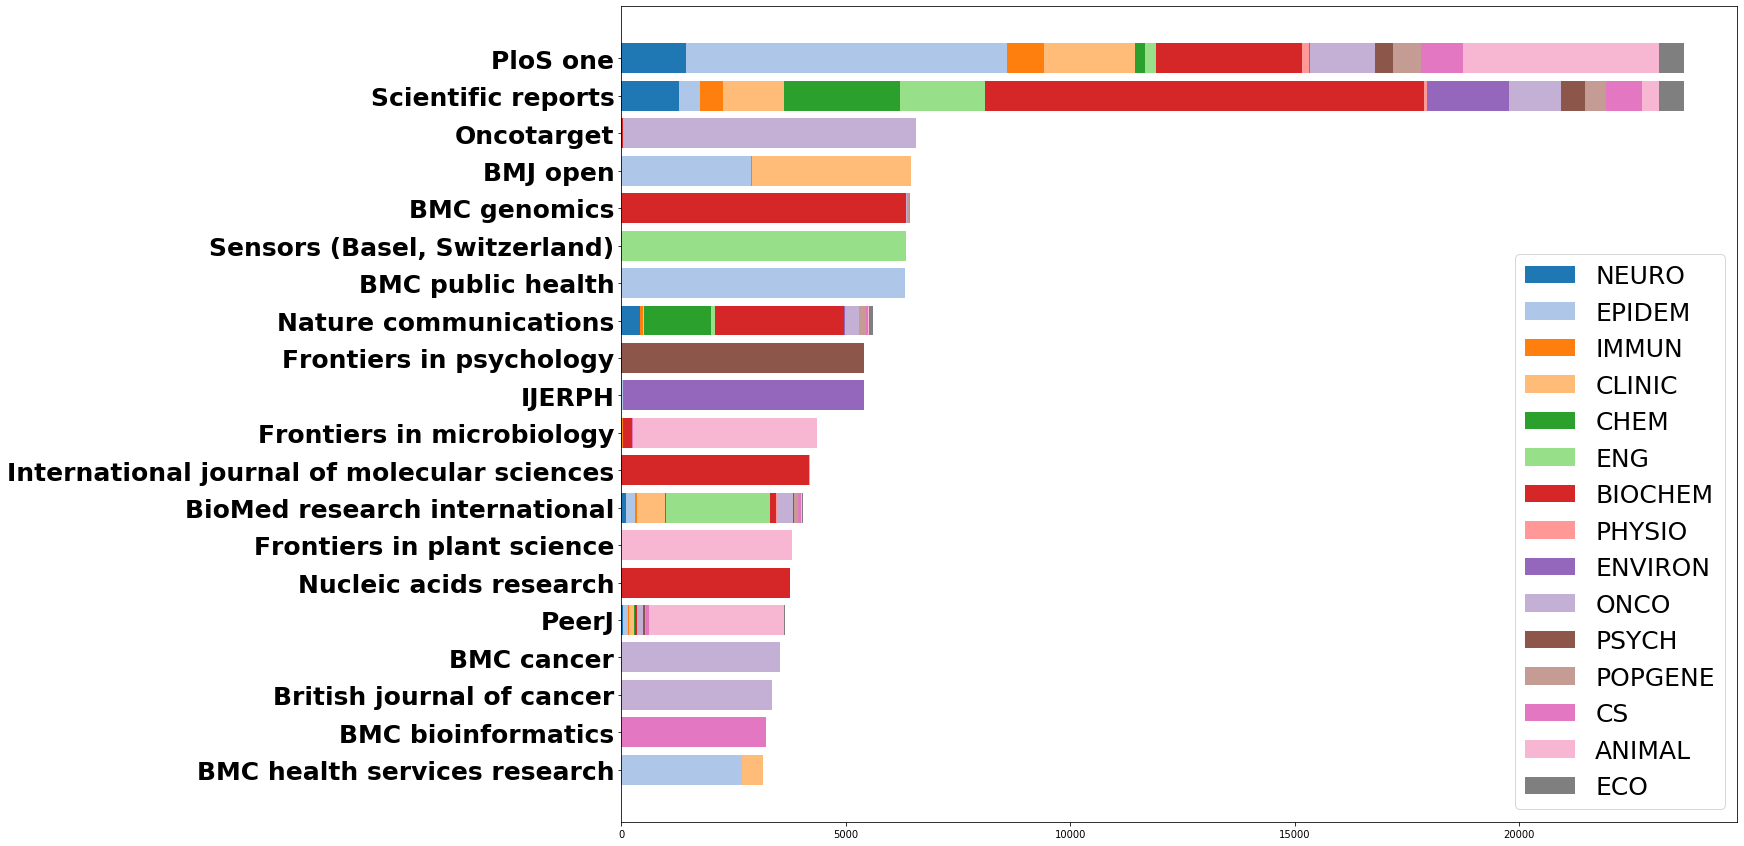

In [18]:
journals = additional_df['journal'].value_counts().sort_values(ascending=False)[:20].index
domains = additional_df['domain'].unique()

journal_domain_counts = []
for journal in journals:
    domain_counts = domain_by_journal.loc[journal].to_dict()
    all_domain_counts = [domain_counts[domain] if domain in domain_counts else 0 for domain in domains]
    all_domain_counts_perc = [domain for domain in all_domain_counts]
    journal_domain_counts.append(all_domain_counts_perc)

journal_domain_counts = np.array(journal_domain_counts)
fig, ax = plt.subplots(figsize=(20,15))
ypos = np.arange(len(journals))
cmap = cm.tab20  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
for indx, domain, color in zip(range(len(domains)), domains, cmaplist):
    bottom=journal_domain_counts[:,:indx].sum(axis=1)
    ax.barh(ypos, journal_domain_counts[:,indx], left=bottom, color=color, label=domain)
ax.set_yticks(ypos)
new_journal_names = ['IJERPH' if 'International journal of environmental' in journal
                     else journal 
                     for journal in journals]
ax.set_yticklabels(new_journal_names, fontweight='bold', fontsize=25)
ax.invert_yaxis()  # labels read top-to-bottom
# plt.xlim(0,1.5)
plt.legend(fontsize=25)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure2/Journal_Counts.png', bbox_inches='tight')

## 1.4. Top Entities

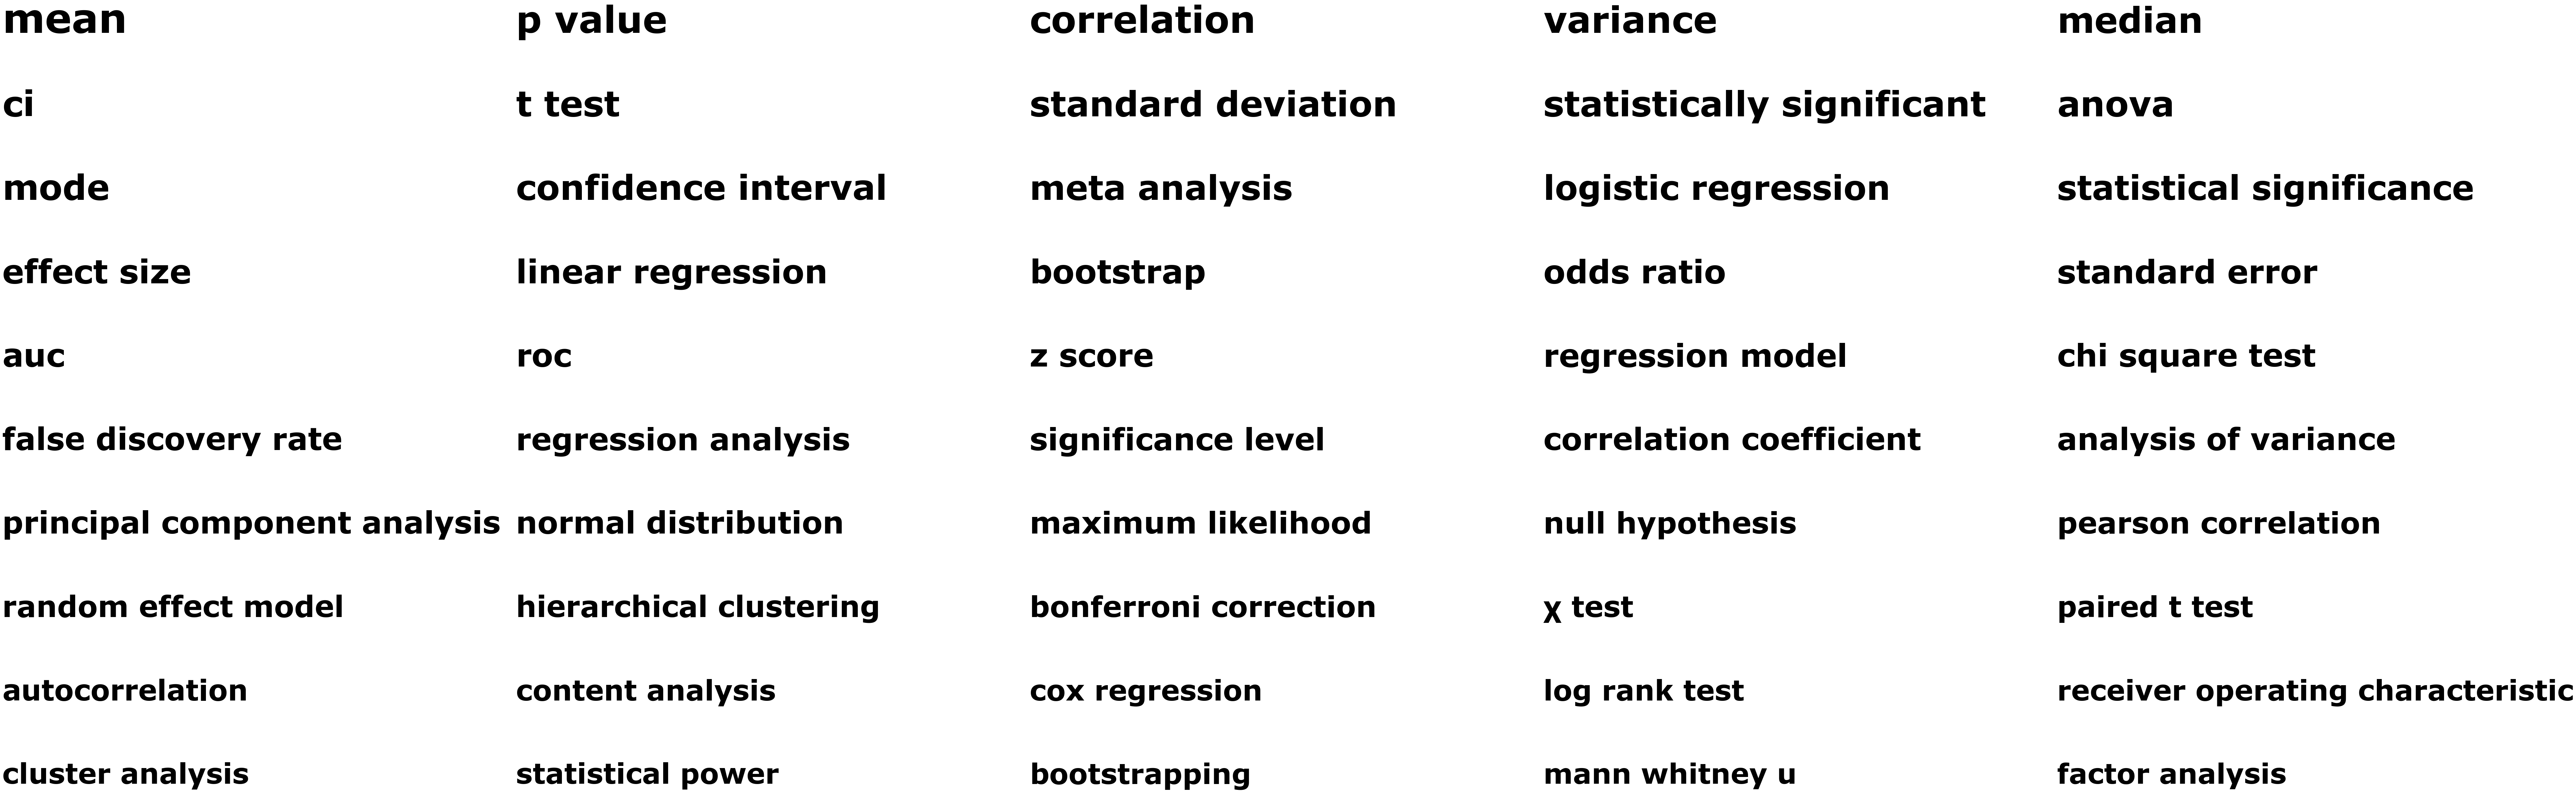

In [19]:
y_list = [num for num in range(10) for y in range(5)][::-1]
x_list = [x for num in range(10) for x in range(5)]
ent_sums = Counter(ent_obj.ents['vocab_count']).most_common(50)
fig, ax = plt.subplots(figsize=(30,5))
for i, ent in enumerate(ent_sums):
    size = ent[1]
    x = x_list[i]
    y = y_list[i]
    ax.text(x, y, ent[0], fontsize=np.log(size)*10, fontweight='bold', family='Verdana')
fig.patch.set_visible(False)
ax.axis('off')
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure2/Entity_Counts.png', bbox_inches='tight')

# 2. Entity Trends

## 2.1. Initialize and Preprocess 

### 2.1.1. Load and Initialize EntityTrends Object

* As described in the paper, we use the manually classified method *categories* for examining entity trends and discipline classification - as opposed to the original method entity counts

In [20]:
ent_obj = pickle.load(open('data/temp_ent_grouped_obj.pickle', 'rb'))
word_count_df, additional_df = ent_obj.convert_to_dataframe(additional_cols=['date', 'domain', 'journal'])
from analysis_main.ents_trends import EntityTrends
ent_trends = EntityTrends('data/ents', 'journal_classification/nb_classifier.pickle', ent_count_thres=5)

### 2.1.2 Downsample PloS One articles

In [21]:
np.random.seed(1)
n_plos_indx = np.where(additional_df.journal == 'PloS one')[0]
n_plos = len(n_plos_indx)
n_sr = (additional_df.journal == 'Scientific reports').sum()
rand_indx = np.random.permutation(n_plos)

plos_exclude = n_plos_indx[rand_indx[:(n_plos - n_sr)]]
plos_exclude_pmids = list(additional_df.iloc[plos_exclude, :].index)
word_count_df = word_count_df.drop(plos_exclude_pmids).copy()
additional_df = additional_df.drop(plos_exclude_pmids).copy()

### 2.1.3. Define time series visualization function (w/ bootstrapped error regions)

In [22]:
def plot_ts_bootstrap(bootstrap_df):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(bootstrap_df.index, bootstrap_df.mean(axis=1), alpha=0.5, color='blue', label='train', linewidth = 2.0)
    ax.fill_between(bootstrap_df.index, bootstrap_df.mean(axis=1) - bootstrap_df.std(axis=1), 
                    bootstrap_df.mean(axis=1) + bootstrap_df.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(bootstrap_df.index, bootstrap_df.mean(axis=1) - 2*bootstrap_df.std(axis=1), 
                    bootstrap_df.mean(axis=1) + 2*bootstrap_df.std(axis=1), color='#888888', alpha=0.2)
    plt.yticks(fontweight='bold', fontsize=15)
    plt.xticks(fontweight='bold', fontsize=15)
    plt.grid(True)

## 2.2. Summary visualization of entity trends

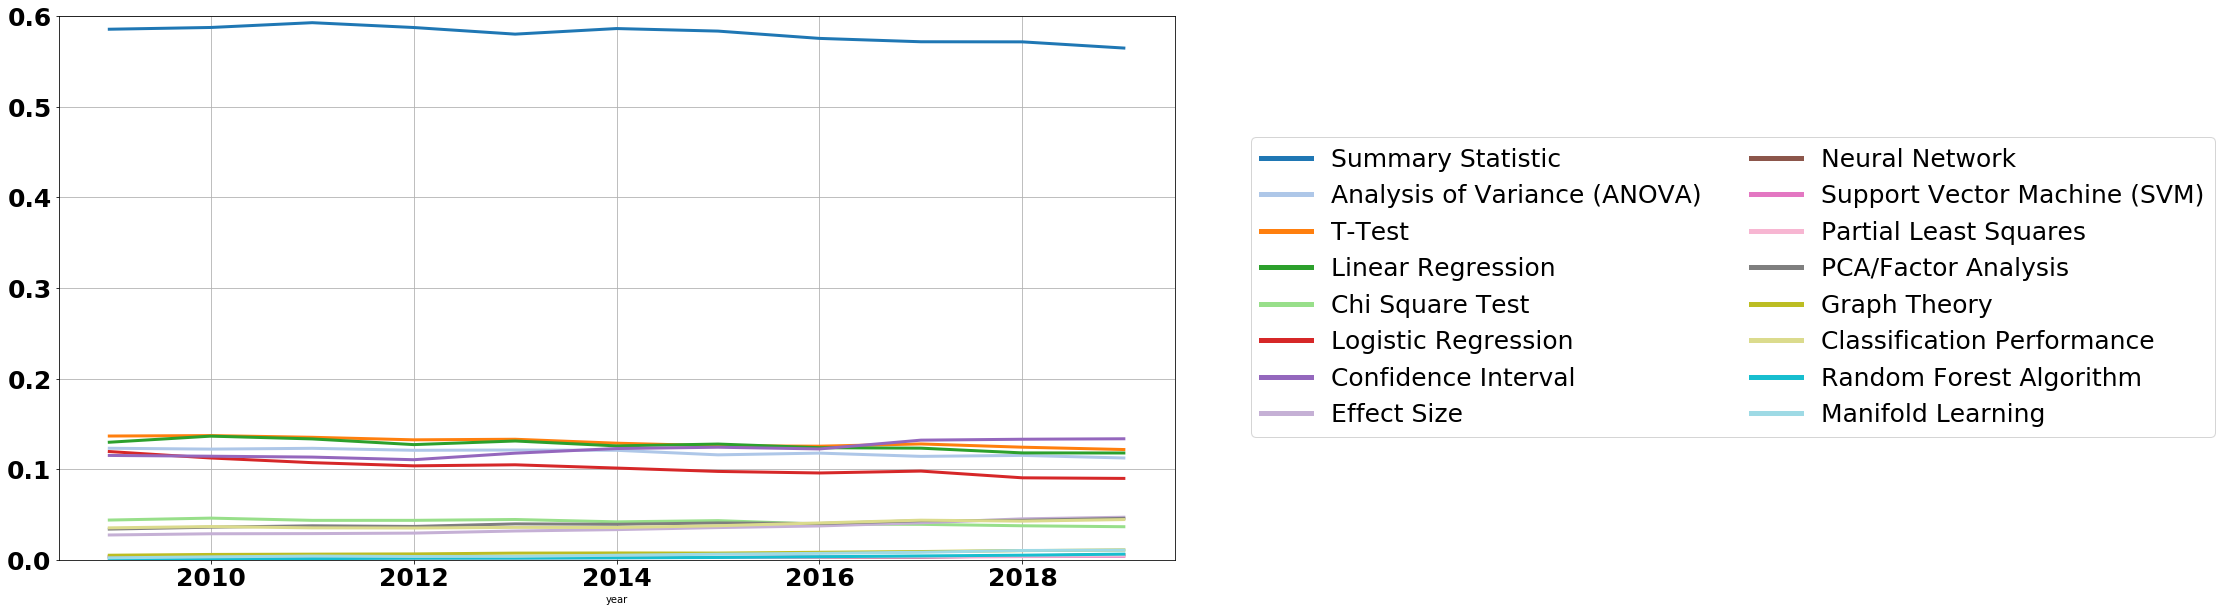

In [23]:
stat_strs = ['summary statistic', 'anova', 't test', 'linear regression', 
             'chi square test', 'logistic regression', 'confidence interval', 'effect size', 
             'neural network', 'support vector machine', 'partial least square',
            'pca/factor analysis', 'graph theory', 'classification accuracy', 'random forest decision tree', 
            'manifold learning']
stat_labels = ['Summary Statistic', 'Analysis of Variance (ANOVA)', 'T-Test', 'Linear Regression',
               'Chi Square Test', 'Logistic Regression', 'Confidence Interval', 'Effect Size', 'Neural Network', 
               'Support Vector Machine (SVM)', 'Partial Least Squares', 'PCA/Factor Analysis', 
               'Graph Theory', 'Classification Performance', 'Random Forest Algorithm', 'Manifold Learning']
resampled_df = ent_trends.entity_ts(word_count_df, additional_df['date'], stat_strs)
ax = resampled_df.plot(figsize=(20,10), grid=True, colormap='tab20', linewidth=3)
plt.yticks(fontweight='bold', fontsize=25)
plt.xticks(fontweight='bold', fontsize=25)
plt.ylim(0, 0.6)
leg = plt.legend(labels=stat_labels, fontsize=25, ncol=2, loc='upper center', bbox_to_anchor=(1, 0, 1, 0.8))
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/All_TS.png', bbox_inches='tight')
# plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/All_TS_subset.png', bbox_inches='tight') # change ylim

## 2.3 Individual entity trend visualization

#### 2.3.1 'Summary Statistic'

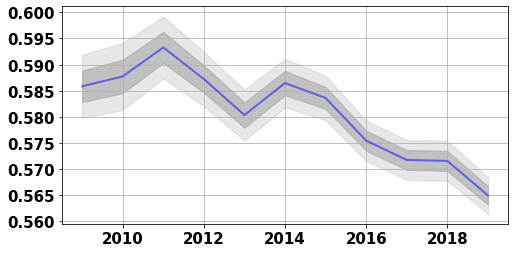

In [24]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                              'summary statistic', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_summary_statistic.png', bbox_inches='tight')

#### 2.3.2 'ANOVA'

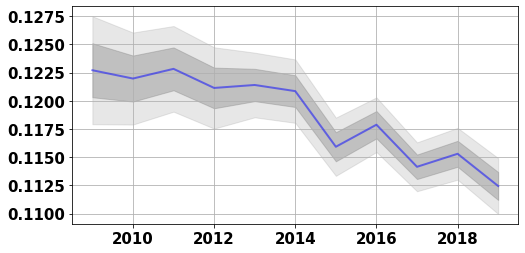

In [25]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'anova', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_anova.png', bbox_inches='tight')

#### 2.3.3 'T Test'

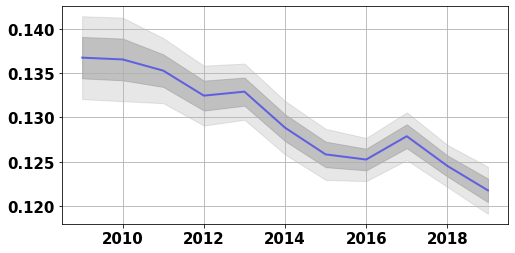

In [26]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   't test', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_t_test.png', bbox_inches='tight')

#### 2.3.4 Linear Regression

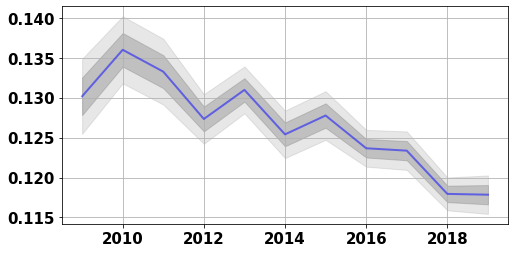

In [27]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'linear regression', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_linear_regression.png', bbox_inches='tight')

#### 2.3.5 Logistic Regression

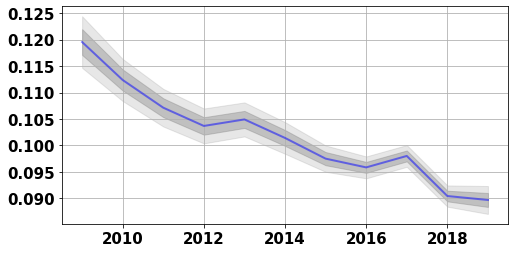

In [28]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'logistic regression', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_logistic_regression.png', bbox_inches='tight')

#### 2.3.5 Neural Network

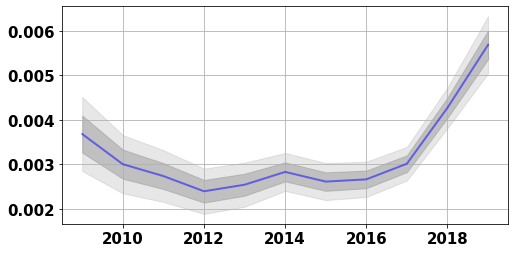

In [29]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                              'neural network', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_neural_network.png', bbox_inches='tight')

#### 2.3.6 Manifold Learning

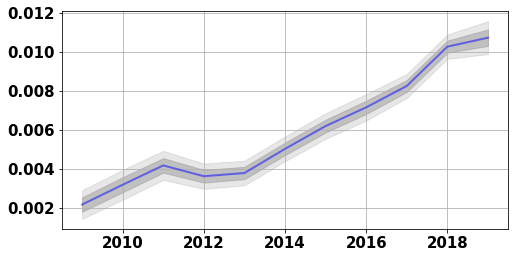

In [30]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                              'manifold learning', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_manifold_learning.png', bbox_inches='tight')

#### 2.3.6 Support Vector Machine

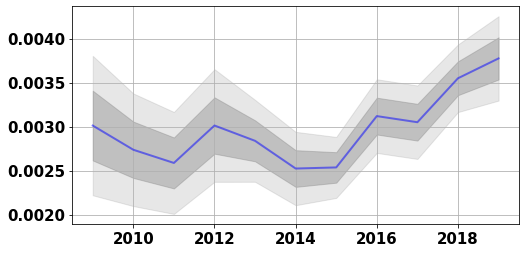

In [31]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                              'support vector machine', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_support_vector_machine.png', bbox_inches='tight')

#### 2.3.7 Partial Least Squares

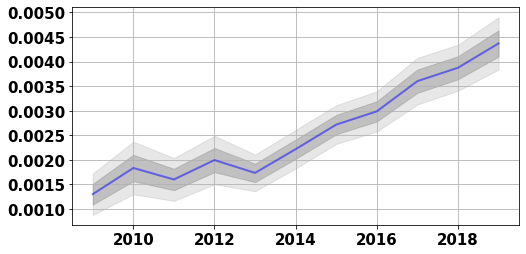

In [32]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'partial least square', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_partial_least_squares.png', bbox_inches='tight')

#### 2.3.8 'PCA/Factor Analysis'

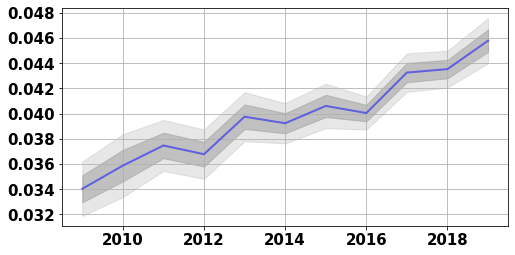

In [33]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'pca/factor analysis', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/pca_factor_analysis.png', bbox_inches='tight')

#### 2.3.9 'Graph Theory'

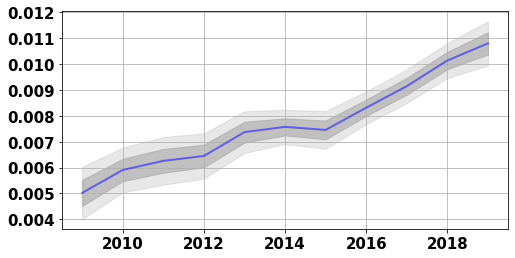

In [34]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'graph theory', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_graph_theory.png', bbox_inches='tight')

#### 2.3.10 'Random Forest'

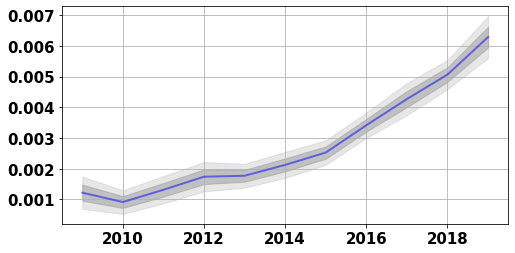

In [35]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                              'random forest decision tree', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_random_forest.png', bbox_inches='tight')

#### 2.3.10 'Classification Performance'

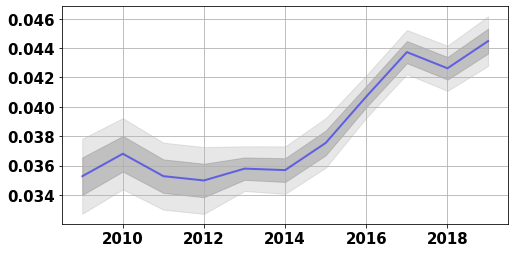

In [36]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'classification accuracy', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_classification_performance.png', bbox_inches='tight')

#### 2.3.11 'Confidence Intervals'

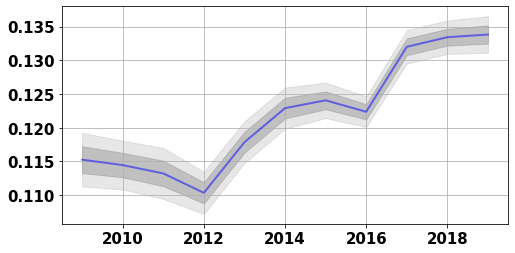

In [37]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'confidence interval', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_confidence_intervals.png', bbox_inches='tight')

#### 2.3.12 'Effect Size'

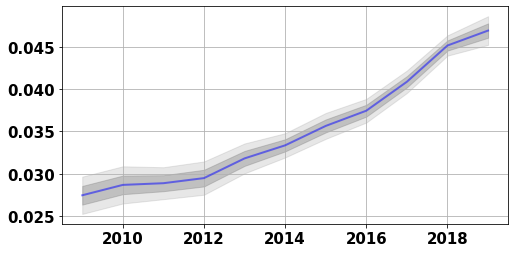

In [38]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'effect size', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_effect_size.png', bbox_inches='tight')

#### 2.3.13 'Chi-Square Statistic'

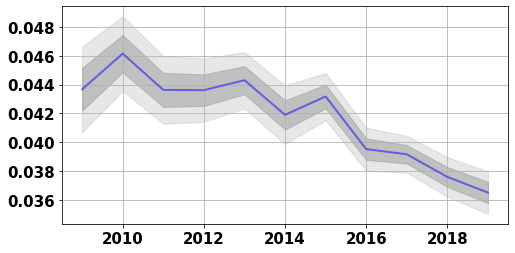

In [39]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'chi square test', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_chi_square.png', bbox_inches='tight')

#### 2.3.14 Mixed Models

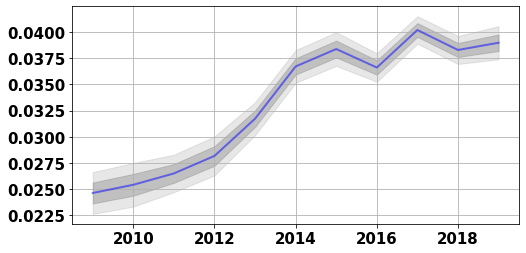

In [40]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'mixed/multilevel model', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_multilevel_model.png', bbox_inches='tight')

#### 2.3.15 Qualitative analysis

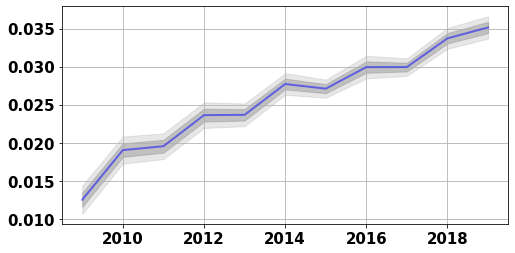

In [41]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'thematic analysis', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_qualitative.png', bbox_inches='tight')

#### 2.3.16 Meta Analysis

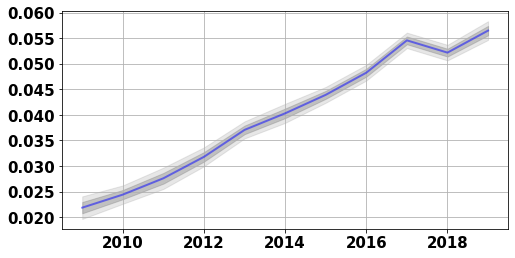

In [42]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'meta analysis', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_meta_analysis.png', bbox_inches='tight')

#### 2.3.17 Survival Models

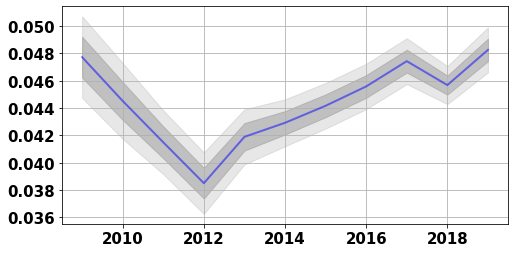

In [43]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'survival model', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_survival_model.png', bbox_inches='tight')

#### 2.3.18 Bayesian Estimation

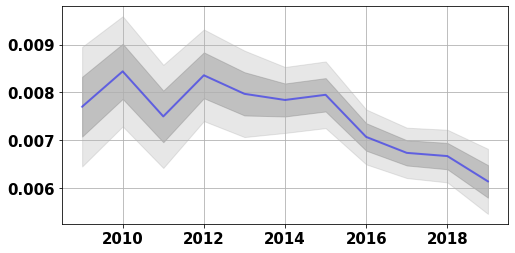

In [44]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'bayesian estimation - general', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_bayesian.png', bbox_inches='tight')

#### 2.3.19 Markov Chain Monte Carlo

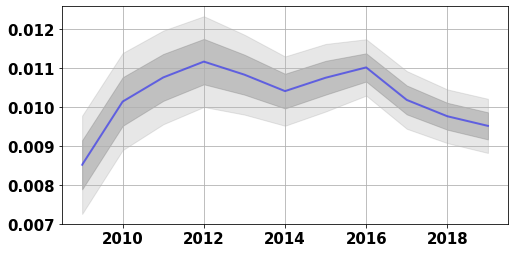

In [45]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'markov chain monte carlo', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_mcmc.png', bbox_inches='tight')

#### 2.3.20 Null-Hypothesis Testing

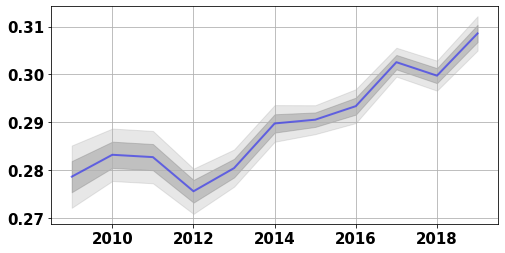

In [46]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'null hypothesis testing', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_null.png', bbox_inches='tight')

#### 2.3.21 Resampling

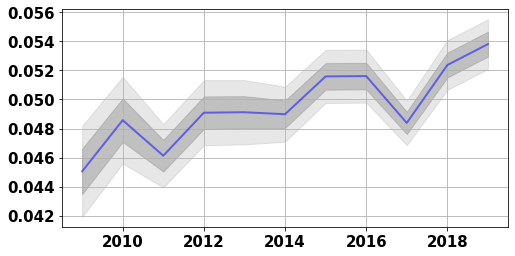

In [47]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'resampling', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_resampling.png', bbox_inches='tight')

#### 2.3.22 Structural Equation Modeling

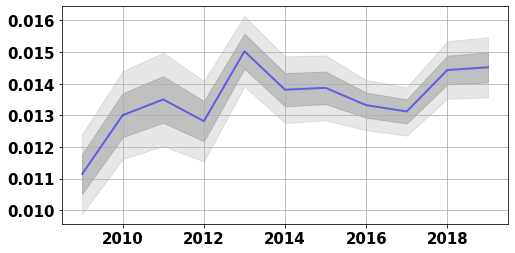

In [48]:
bootstrap_df = ent_trends.entity_ts_bootstrap(word_count_df, additional_df['date'],
                                                   'structural equation modeling', 100)
plot_ts_bootstrap(bootstrap_df)
plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure4/TS_sem.png', bbox_inches='tight')

# 3. Entity Domain by Method Analysis

## 3.1. Intiialize and Preprocess

### 3.1.1 Load and Intiliaze 'EntityDomain' Object

In [4]:
ent_obj = pickle.load(open('data/temp_ent_grouped_obj.pickle', 'rb'))
word_count_df, additional_df = ent_obj.convert_to_dataframe(additional_cols=['domain', 'date', 'journal'])
from analysis_main.ents_domain import EntityDomain
ent_domain = EntityDomain('data/ents', 'journal_classification/nb_classifier.pickle', ent_count_thres=1)
id2vec = {id: voc for voc, id in ent_obj.ents['word_count_matrix']['voc2id'].items()}
ent_labels = [id2vec[indx] for indx in range(len(id2vec))]

### 3.1.2 Downsample PloS One Articles

In [3]:
np.random.seed(1)
n_plos_indx = np.where(additional_df.journal == 'PloS one')[0]
n_plos = len(n_plos_indx)
n_sr = (additional_df.journal == 'Scientific reports').sum()
rand_indx = np.random.permutation(n_plos)

plos_exclude = n_plos_indx[rand_indx[:(n_plos - n_sr)]]
plos_exclude_pmids = list(additional_df.iloc[plos_exclude, :].index)
word_count_df = word_count_df.drop(plos_exclude_pmids).copy()
additional_df = additional_df.drop(plos_exclude_pmids).copy()

NameError: name 'additional_df' is not defined

## 3.2. Contingency Table Analysis

### 3.2.1 Get Domain by Method Entity contingency table

In [4]:
contingency_table = ent_domain.contingency_table(word_count_sp, additional_df['domain'])

### 3.2.2 Visualize top method entities for each discipline

In [20]:
domain = 'PSYCH'
contingency_table.standardized_resids.loc[domain].sort_values(ascending=False)[:10]

structural equation modeling                    103.332490
effect size                                      67.407370
maximum likelilhood                              38.862538
mediation analysis                               29.433880
listwise deletion                                24.623619
weighted/generalized least square estimation     24.369469
growth curve model                               23.539010
polychoric correlation                           20.007562
mixed/multilevel model                           19.975715
cronbach's alpha                                 18.963510
Name: PSYCH, dtype: float64

# 4. Tensor Decomposition Analysis (i.e. 'Method Family' Analysis)

## 4.1. Initialize and Preprocess

### 4.1.1 Load and Intiliaze 'EntityNetwork' Object

In [2]:
ent_obj = pickle.load(open('data/temp_ent_obj.pickle', 'rb'))
word_count_df, additional_df = ent_obj.convert_to_dataframe(additional_cols=['domain', 'journal'])
from analysis_main.ents_network import EntityNetwork
ent_network = EntityNetwork('data/ents', 'journal_classification/nb_classifier.pickle', ent_count_thres=1)
voc2id = ent_obj.ents['word_count_matrix']['voc2id']
id2voc = {id: voc for voc, id in ent_obj.ents['word_count_matrix']['voc2id'].items()}
ent_vocab = [id2voc[i] for i in range(len(voc2id))]

### 4.1.2 Downsample PloS One Articles

In [3]:
np.random.seed(1)
n_plos_indx = np.where(additional_df.journal == 'PloS one')[0]
n_plos = len(n_plos_indx)
n_sr = (additional_df.journal == 'Scientific reports').sum()
rand_indx = np.random.permutation(n_plos)

plos_exclude = n_plos_indx[rand_indx[:(n_plos - n_sr)]]
plos_exclude_pmids = list(additional_df.iloc[plos_exclude, :].index)
word_count_df = word_count_df.drop(plos_exclude_pmids).copy()
additional_df = additional_df.drop(plos_exclude_pmids).copy()

word_count_sp = sp.csr_matrix(word_count_df.values)

## 2. Tensor Decomposition

In [7]:
networks = ent_network.compute_network_by_domain(word_count_sp,additional_df['domain'])
ent_network.tensor_decomp(networks, 21, ent_obj.ents['word_count_matrix']['voc2id'])

## 3. Plot Tensors

/Users/taylor_bolt/miniconda3/envs/stats_history/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


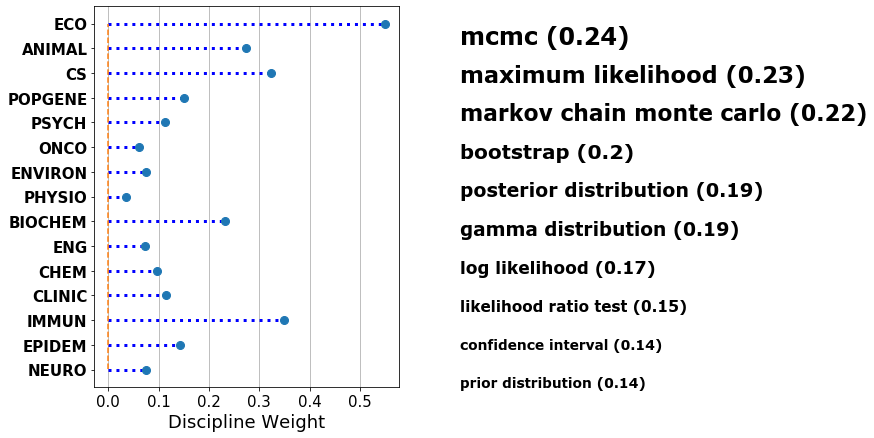

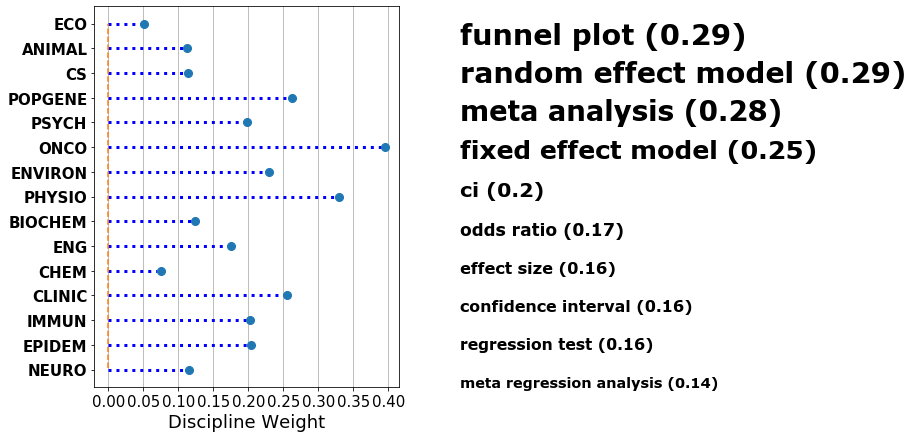

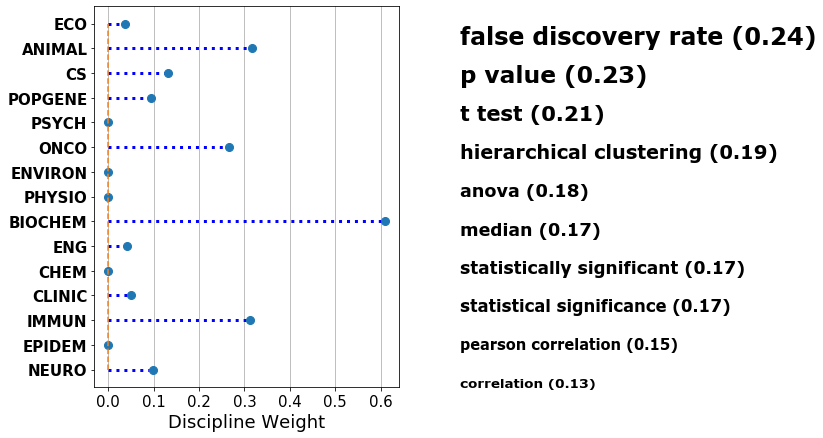

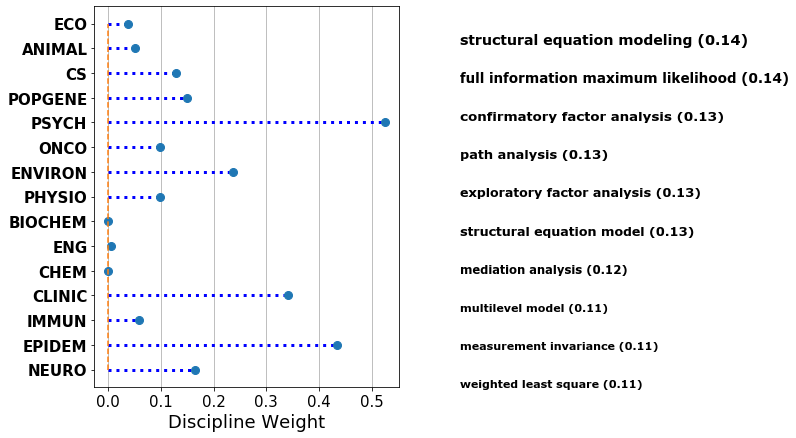

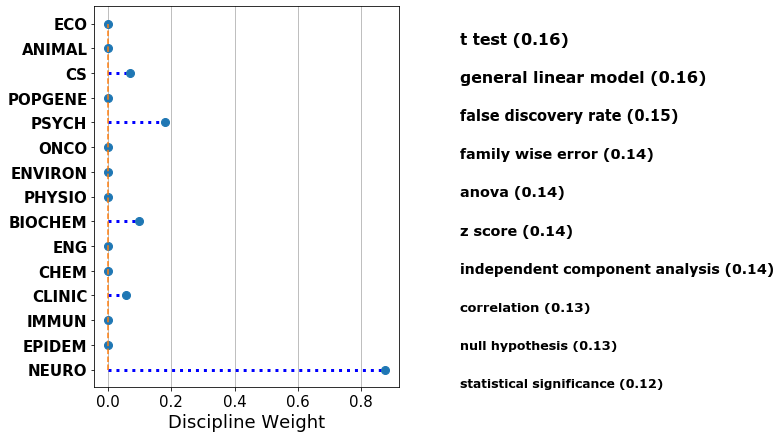

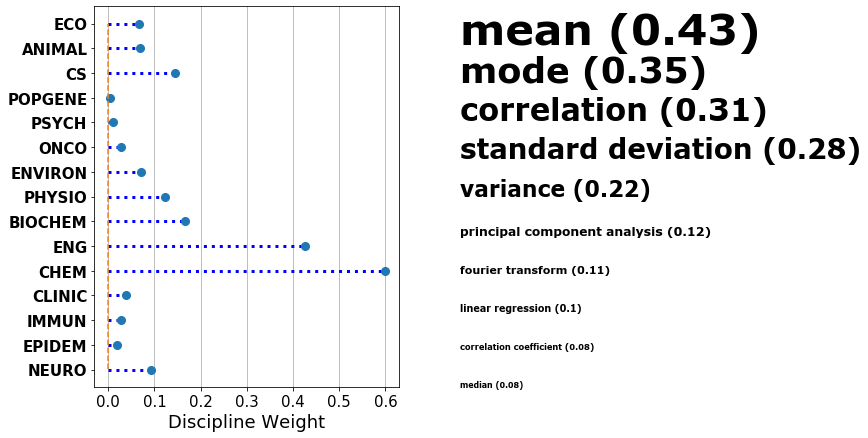

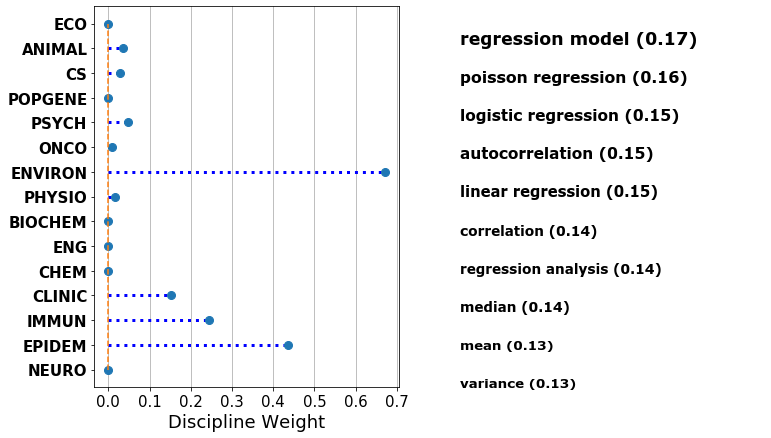

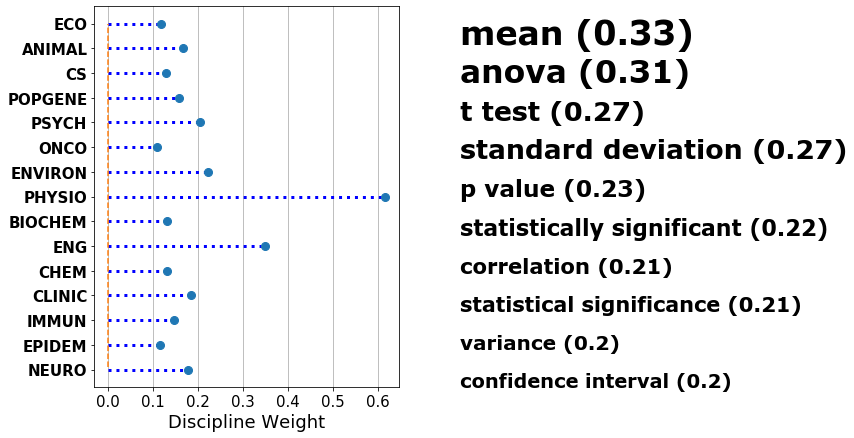

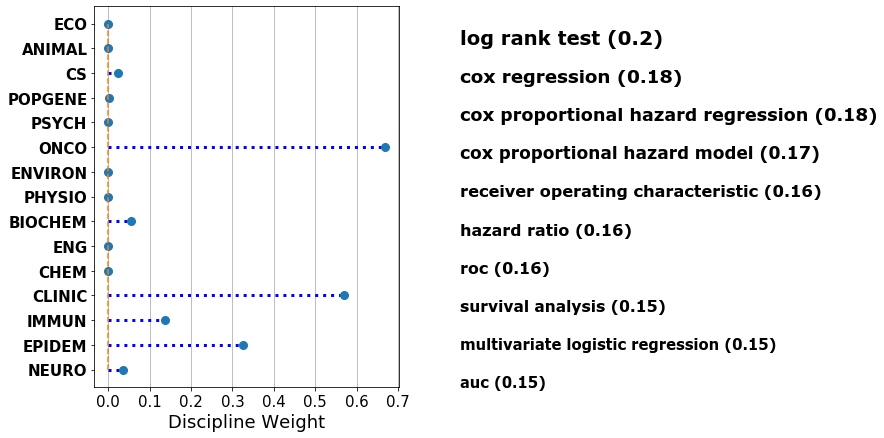

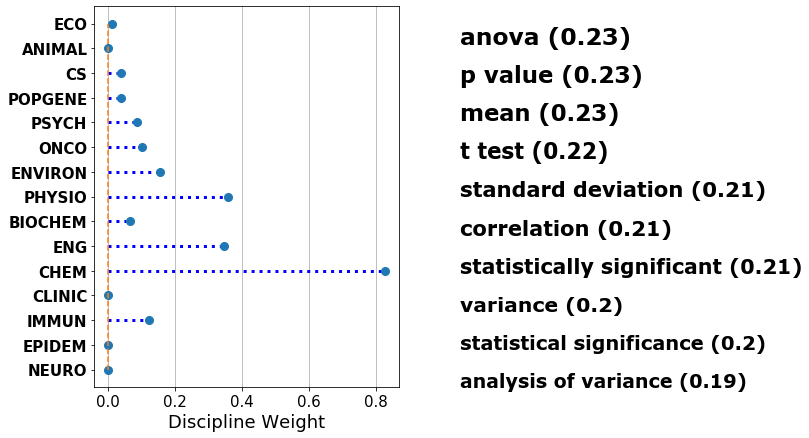

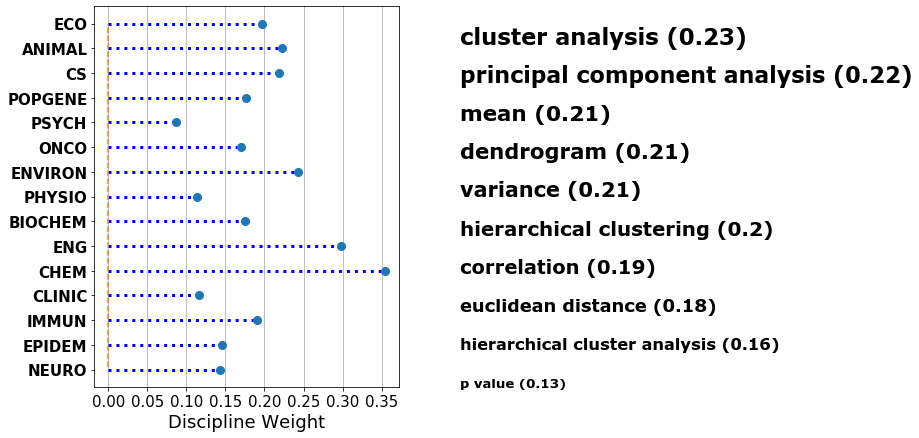

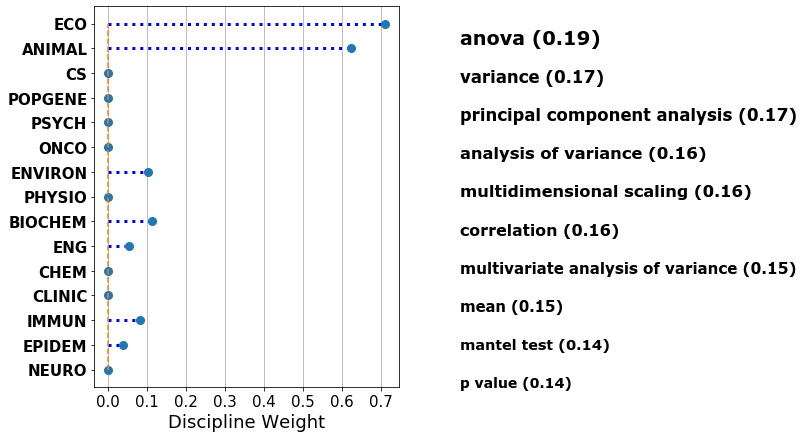

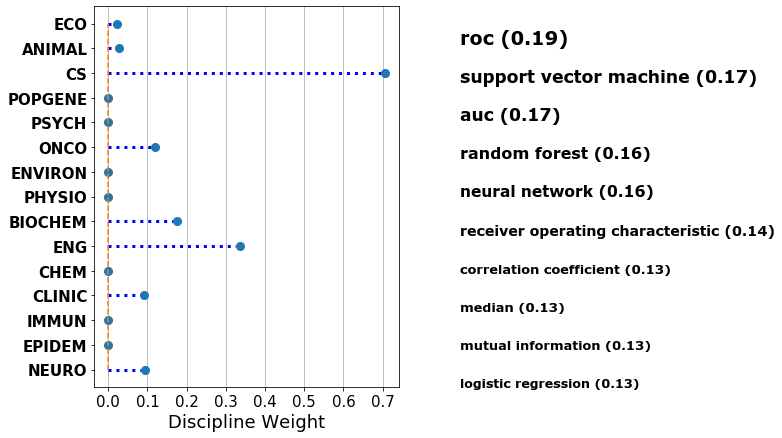

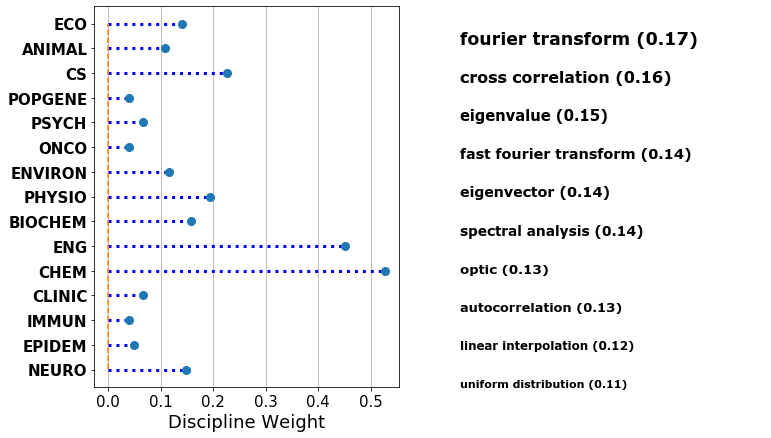

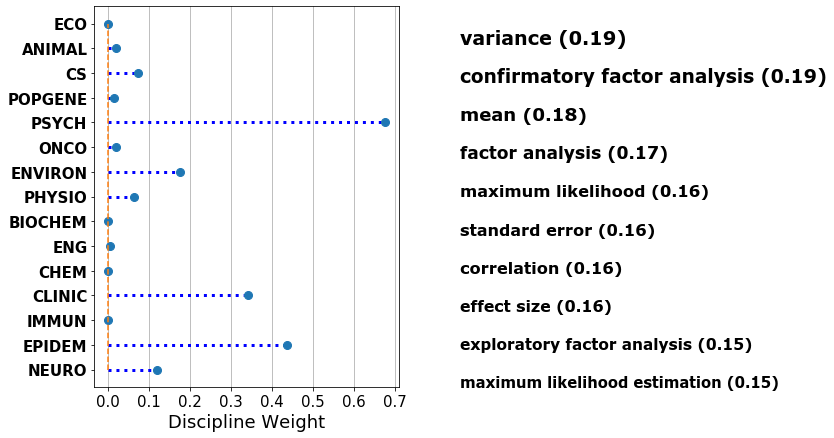

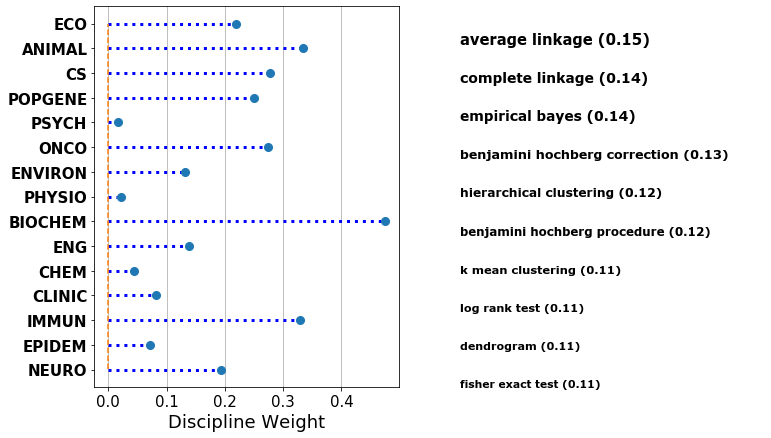

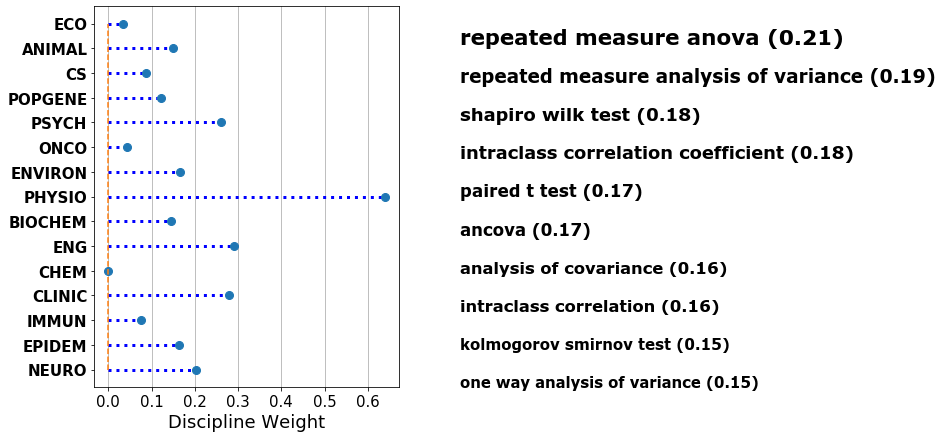

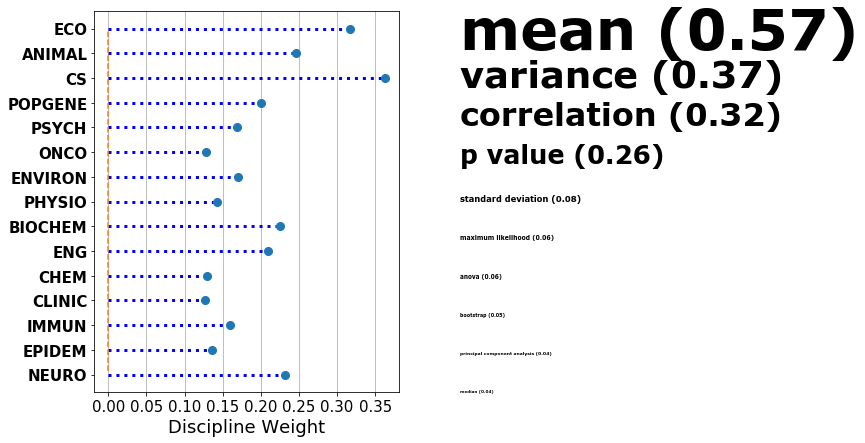

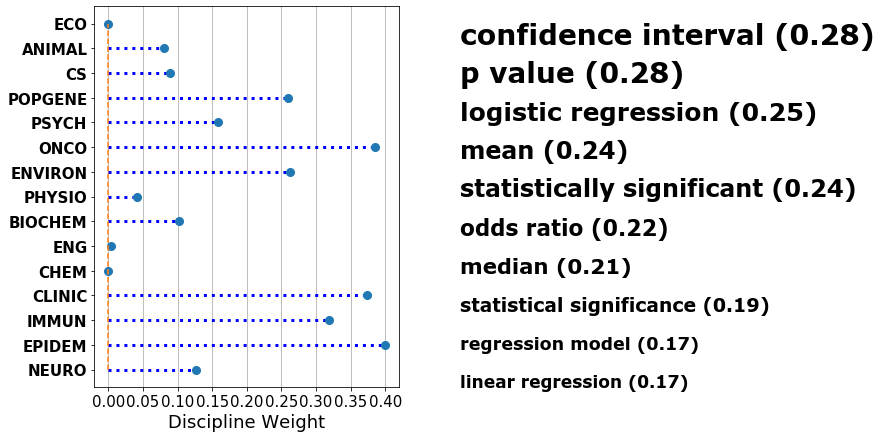

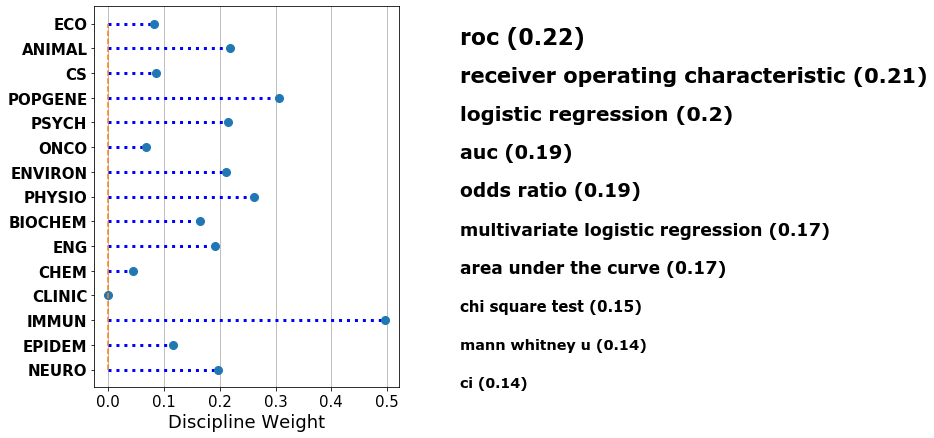

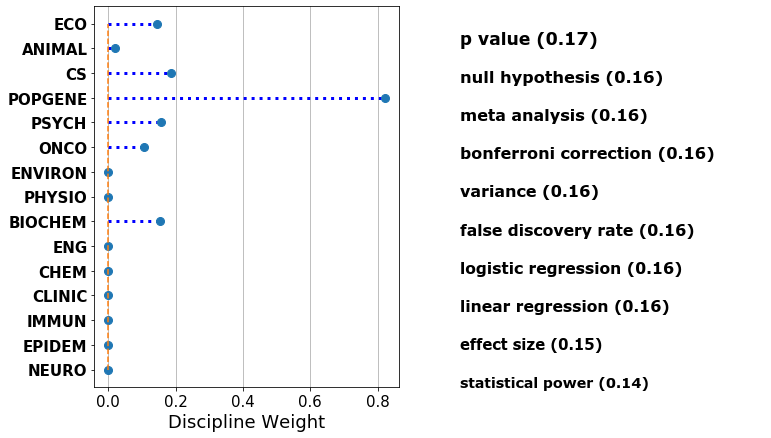

In [8]:
for comp in range(21):
    fig, axs = plt.subplots(1,2,figsize=(12,7))
    domain_weights = ent_network.factors[2][:,comp]
    ent_weights = ent_network.factors[0][:,comp]
    top10_indx = np.flip(ent_weights.argsort())[:10]
    axs[0].hlines(np.arange(15), 0, domain_weights, color='blue', linestyles=':', linewidth=3)  # Stems
    axs[0].plot(domain_weights, np.arange(15), 'o', markersize=8)  # Stem ends
    axs[0].plot([0, 0], [domain_weights.min(), np.arange(15).max()], '--')  # Middle bar
    plt.sca(axs[0])
    plt.yticks(np.arange(15), ent_network.network_domains, size=15, weight='bold')
    plt.xticks(size=15)
    plt.grid(axis='x')
    plt.xlabel('Discipline Weight', fontsize=18)
    y = 1
    for indx in top10_indx:
        size = ent_weights[indx]
        label = id2voc[indx] + f' ({round(size,2)})'
        y -= 0.1
        axs[1].text(0, y, label, fontsize=size*100, fontweight='bold', family='Verdana')
    axs[1].axis('off')
    plt.savefig(f'/Users/taylor_bolt/Desktop/Publishing/Stats_Mining/Figures/Figure6/Comp_Weights/C21/Comp_{comp}.png', bbox_inches='tight')

In [15]:
from analysis_main.ents_compare import EntityCompare
ent_compare = EntityCompare('data/ents', 'journal_classification/nb_classifier.pickle')
ent_compare.compute_entity_vectors(ent_obj.ents['word_count_matrix']['matrix'])
ent_compare.query_nearest_neighbors('summary statistic', ent_obj.ents['word_count_matrix']['voc2id'])
# voc2id = ent_obj.ents['word_count_matrix']['voc2id']
# id2voc = {id: voc for voc, id in voc2id.items()}
# sparse_vectors = ent_compare.compute_sparse_entity_vectors()

No nearest neighbor model detected, running initial model.This may take a minute.
summary statistic : 0.0 

cronbach's alpha : 0.77620164754901 

multiple comparison correction : 0.7772836220844003 

normality test : 0.8629481336451609 

rank correlation : 0.8680102281060714 

signal processing - general : 0.8789423869593259 

nonlinear regression : 0.8792035266144771 

fishers exact test : 0.8869981267216188 

pca/factor analysis : 0.8892305795961779 

image analysis : 0.891454200321445 



/Users/taylor_bolt/miniconda3/envs/stats_history/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [30]:
ent_compare.sim_mat[50,11]

1.1472044708566715

# IV. Data Checks

## 1. Pull Article Dicts

In [3]:
ent_files = glob('data/ents/*pickle')
# article_dicts = []
# for file in ent_files:
#     ents = pickle.load(open(file, 'rb'))
#     article_dicts += ents

article_dicts = pickle.load(open(ent_files[0], 'rb'))
# convert list of pubmed dicts to dictionary indexed by pmid
article_dicts = {article['pmid']: article for article in article_dicts}

## 2. Why so many 'Thematic Analysis' methods in Public/Health Epidemiology?

In [4]:
ent_obj = pickle.load(open('data/temp_ent_grouped_obj.pickle', 'rb'))
word_count_df, additional_df = ent_obj.convert_to_dataframe(additional_cols=['date', 'domain'])

In [23]:
article_dict_boolean = [pmid in article_dicts.keys() for pmid in additional_df.index] 
thematic_mask = (additional_df['domain'] == 'EPIDEM') & (word_count_df['thematic analysis'] == 1)  & article_dict_boolean
word_count_thematic = word_count_df.loc[thematic_mask, :]

In [24]:
article_dicts[word_count_thematic.index[8]]

{'title': 'Different models of HPV vaccine decision making among adolescent girls, parents, and health care clinicians in New Mexico',
 'abstract': '  Objective  HPV vaccination rates in the United States have been lower than anticipated since the vaccine became widely available globally in 2006. Of particular concern are data that suggest disparities in vaccine receipt among U.S. ethnic minority and health disparity populations such as Hispanics, who are disproportionately affected by cervical cancer. Given these trends, it is important to examine actual vaccination decision making processes among clinicians, parents, and adolescents to identify strategies to enhance uptake.    Design  We conducted a mixed-method study examining HPV vaccine decision making, utilizing both structured questionnaires of mothers and daughters and semi-structured interviews with mothers, daughters, and healthcare clinicians to more deeply investigate decision-making dynamics. Quantitative analysis was used

**SUMMARY**: Looks like there is a lot of use of focus groups and interviews in public health interventions. These data collection techniques naturally lend themselves to thematic analysis.